# Topic modelling

## Install rapidsai and *cuml* and configure Google Colab

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'
!pip uninstall cupy -y

In [ ]:
!conda install_rapids cuml

In [ ]:
import cuml
from cuml.manifold import UMAP

### Google colab config.

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')  # This will prompt for authorization

In [ ]:
# Check memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f'Your runtime has {ram_gb:.1f} gigabytes of available RAM\n')

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
# Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

In [9]:
# !pip3 install bertopic
# !pip3 install openTSNE
import pickle
import openai
import hdbscan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN
from openTSNE import TSNE as oTSNE
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

## Embeddings

In [ ]:
# Word embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

sports_embeddings_256 = sentence_model.encode(docs, convert_to_numpy=True)

np.save('/content/drive/MyDrive/sports_embeddings_256', sports_embeddings_256)

In [ ]:
# load sentence data set 
transcripts = pd.read_csv('/content/drive/MyDrive/sport_sent_1.csv.gz', compression='gzip', usecols=[2])
print(transcripts.shape)
print(transcripts.head(2))  

docs = transcripts.transcript_subset.to_list()
print(len(docs))

# Sentence embeddings
sports_embeddings_sentence_1 = sentence_model.encode(docs, convert_to_numpy=True)

np.save('/content/drive/MyDrive/sports_embeddings_sentence_1', sports_embeddings_sentence_1)

In [12]:
# initialize and dim reduce data to 50/100 dimensions using PCA, save PCA class object
embeddings_sent = np.load('sports_embeddings_256.npy')
PCA_model = PCA(n_components=50)

with open('pca_model_word50.pkl', 'wb') as pca_outp:  # OBS create pkl file in dir
    PCA_embeddings = PCA_model.fit_transform(embeddings_sent)
    pickle.dump(PCA_model, pca_outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Initialize and rescale PCA embeddings and dim reduce using t-SNE, save dim reduced embeddings and t-SNE class object
TSNE = oTSNE(n_components=3, verbose=True)

# dim reduce and save t-SNE class object for prediciton
with open('tsne_data.pkl', 'wb') as outp:  # OBS create pkl file in dir
    tsne_dimreduced_embeddings = TSNE.fit(PCA_embeddings)
    pickle.dump(tsne_dimreduced_embeddings, outp, pickle.HIGHEST_PROTOCOL)

# save embeddings
np.save('/content/drive/MyDrive/tsne_dimred_embeddings', tsne_dimreduced_embeddings)

## Implement BERTopic-like pipeline

### HDBSCAN

In [5]:
# Load data and embeddings 
modelling_data = pd.read_csv('../Thesis/Final_models/plain_data_sports_word.csv.gz', compression='gzip', usecols=[2])
modelling_documents = modelling_data.transcript_subset.to_list()
print(len(modelling_documents))

modelling_tsne_data = np.load('../Thesis/Final_models/tsne_dimred_embeddings_word100.npy')
modelling_tsne_data.shape

368835


(368835, 2)

In [30]:
hdbscan_model = HDBSCAN(
    min_cluster_size = 50,  # test 15, 50 and 200
    metric='euclidean', # same as cosine for normalised data
    cluster_selection_method='eom', 
    algorithm='best',
    prediction_data=True)

# save hdbscan as pickle for downstream transfer 
with open('../Thesis/Final_models/hdbscan_msize50.pkl', 'wb') as outp:  # OBS create pkl file in dir
    hdbscan_model.fit(modelling_tsne_data)
    pickle.dump(hdbscan_model, outp, pickle.HIGHEST_PROTOCOL)

### Topic model investigation

In [66]:
# optional model load
with open('../Thesis/Final_models/hdbscan_msize50.pkl', 'rb') as inp:
    hdbscan_model = pickle.load(inp)

Number of topics: 556
Amount of noise: 185500
Top cluster size: 11970


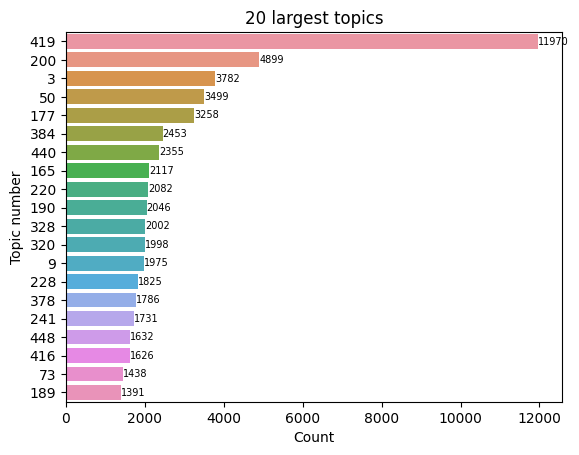

In [67]:
# HDBSCAN results dataframe
hdbscan_df = pd.DataFrame({'transcript': modelling_documents, 
                           'cluster_label':hdbscan_model.labels_})

# HDBSCAN results dataframe without outliers
hdbscan_df_noout = hdbscan_df[hdbscan_df.cluster_label != -1]


print(f'Number of topics: {len(hdbscan_df.cluster_label.unique())}')
print(f'Amount of noise: {len(hdbscan_df)- len(hdbscan_df_noout)}')
print(f'Top cluster size: {hdbscan_df_noout.cluster_label.value_counts().head(1).iloc[0]}')

# cluster distribution
top_clusters = hdbscan_df_noout.cluster_label.value_counts().head(20)
ax = sns.barplot(x=top_clusters.values, y=top_clusters.index, orient='h', order=top_clusters.index)
ax.set_ylabel('Topic number')
ax.set_xlabel('Count')
ax.set_title('20 largest topics')
plt.rcParams.update({'font.size': 7})  # decrease font size
ax.bar_label(ax.containers[0])
plt.rcParams.update({'font.size': 10})  # return to normal font size
plt.show()


### Tokeniser and Weighting scheme

In [3]:
# optional model load
with open('../Thesis/Final_models/hdbscan_msize200.pkl', 'rb') as inp:
    hdbscan_model = pickle.load(inp)

In [6]:
# we need to treat all documents of each cluster as a single document and get the BoW representations for each cluster
# Create df with cluster labels and coresponding docs 
cluster_df = pd.DataFrame({'document':modelling_documents, 'cluster_label': hdbscan_model.labels_})
cluster_df_no_outliers = cluster_df[cluster_df.cluster_label != -1]

# create concatenated documents for each cluster
cluster_labels = cluster_df_no_outliers.cluster_label.unique()

docu_ls = []
for label in cluster_labels:
    temp_df = cluster_df_no_outliers[cluster_df_no_outliers.cluster_label == label]
    document = ''.join(temp_df.document.to_list())
    docu_ls.append(document)

cluster_document_df = pd.DataFrame({'cluster': cluster_labels, 'cluster_document': docu_ls})

print(cluster_document_df.shape)

(155, 2)


In [7]:
cluster_document_df.head(2)

,cluster,cluster_document
0,18,"as well as several other changes, so we'll get..."
1,77,they put the military-grade telescope out in t...


In [8]:
from ctfidf import CTFIDFVectorizer 

# Create c-TF-IDF, !!OBS!! takes long time
count_vectoriser = CountVectorizer(stop_words='english').fit(cluster_document_df.cluster_document)
count = count_vectoriser.transform(cluster_document_df.cluster_document)
words = count_vectoriser.get_feature_names_out() ; print('CV done')
ctfidf = CTFIDFVectorizer().fit_transform(X = count, n_samples = len(cluster_df_no_outliers)).toarray() ; print('ctfidf done')
words_per_class = {cluster_document_df.cluster[label]: [words[index] for index in ctfidf[label].argsort()[-10:]] 
                   for label in cluster_df_no_outliers.cluster_label}

CV done
ctfidf done


In [9]:
# save representation DFs 
pd.DataFrame(words_per_class).to_csv('../Thesis/evaluation/ctfidf_200.csv')

In [12]:
# Print topic representations for top 5 clusters for HDBSCAN model mpts 15
top_5_ordered_15 = ['1273', '264', '657', '484', '39']
ctfidf_15 = pd.read_csv('../Thesis/evaluation/ctfidf_15.csv')
ctfidf_15_clean = ctfidf_15.loc[:,top_5_ordered_15]
ctfidf_15_clean

,1273,264,657,484,39
0,smackdown,sri,tee,gordon,exercises
1,ring,batting,courses,pats,trainer
2,wcw,indian,tour,julian,halter
3,rumble,indies,swing,afc,exercise
4,wrestlemania,wickets,rory,gronk,horsemanship
5,nxt,bowling,golfers,patriot,clicker
6,wrestlers,batsman,golfer,patriots,saddle
7,wrestle,pakistan,pga,edelman,behavior
8,wrestler,india,golf,belichick,reinforcement
9,wwe,cricket,tiger,brady,horses


In [13]:
# Print topic representations for top 5 clusters for HDBSCAN model mpts 50
top_5_ordered_50 = ['419', '200', '3', '50', '177']
ctfidf_50 = pd.read_csv('../Thesis/evaluation/ctfidf_50.csv')
ctfidf_50_clean = ctfidf_50.loc[:,top_5_ordered_50]
ctfidf_50_clean

,419,200,3,50,177
0,offensive,wrestlemania,australia,catch,stanley
1,backs,nxt,batting,rod,hockey
2,tight,matches,indian,kayak,toronto
3,touchdown,wrestlers,batsman,boat,defenseman
4,tackle,wrestle,bowling,lake,bruins
5,linebacker,ring,pakistan,water,maple
6,receivers,match,england,bass,matthews
7,yards,wrestler,test,bait,babcock
8,wide,wwe,india,fishing,nhl
9,receiver,wrestling,cricket,fish,leafs


In [14]:
# Print topic representations for top 5 clusters for HDBSCAN model mpts 200
top_5_ordered_200 = ['125', '62', '37', '18', '120']
ctfidf_200 = pd.read_csv('../Thesis/evaluation/ctfidf_200.csv')
ctfidf_200_clean = ctfidf_200.loc[:,top_5_ordered_200]
ctfidf_200_clean

,125,62,37,18,120
0,guy,ran,boston,innings,program
1,line,pace,stanley,sox,basketball
2,ball,races,puck,astros,parents
3,quarterback,mile,ice,series,high
4,defense,miles,playoffs,runs,college
5,offense,run,bruins,bullpen,coaching
6,running,training,blues,brewers,coaches
7,wide,running,nhl,yankees,kids
8,yards,marathon,leafs,baseball,school
9,receiver,race,hockey,pitching,coach


### Topic representation tuning with GPT-3

In [36]:
with open('api_key.txt', 'r') as file:
    my_api_key = file.read()


openai.api_key = my_api_key

for col in ctfidf_200_clean.columns:
    topic_rep = ctfidf_200_clean.loc[:,col].to_list()

    gpt_prompt =f"""
    I have a topic that is described by the following keywords:{topic_rep}.

    Based on the information above, describe the topic with approximately four words that would be descriptive for industries that want to advertise products or services related to the topic.
    """

    message_array = [{'role':'user', 
                    'content': gpt_prompt}]

    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=message_array,
    temperature=0.5,
    top_p=1.0,
    max_tokens=150,
    presence_penalty= -0.5, # increase the probability of using the same words as in the prompt
    frequency_penalty= -0.5 # increase the probability of using the same words as in the prompt
    )

    print(response.choices[0].message['content'])

Football game advertising.
Running and Marathon Training.
NHL Playoffs Advertising Opportunities.
Baseball Playoff Advertising.
Youth Basketball Coaching Services.


### Look-up topic ctf-idf and GPT representations for individual topics

In [21]:
# Print topic representation
# input
topic_number = '125'
hdbscan_model_number = 200

# generate output
ctfidf_df = pd.read_csv(f'../Thesis/evaluation/ctfidf_{hdbscan_model_number}.csv')
ctfidf_df_clean = ctfidf_df.loc[:,topic_number]
print('ctf-idf representation')
print(ctfidf_df_clean)

# GPT 
with open('api_key.txt', 'r') as file:
    my_api_key = file.read()

openai.api_key = my_api_key

gpt_prompt =f"""
I have a topic that is described by the following keywords:{ctfidf_df_clean}.

Based on the information above, describe the topic with approximately four words that would be descriptive for industries that want to advertise products or services related to the topic.
"""

message_array = [{'role':'user', 
                'content': gpt_prompt}]

response = openai.ChatCompletion.create(
model="gpt-3.5-turbo",
messages=message_array,
temperature=0.5,
top_p=1.0,
max_tokens=150,
presence_penalty= -0.5, # increase the probability of using the same words as in the prompt
frequency_penalty= -0.5 # increase the probability of using the same words as in the prompt
)

print('GPT representation')
print(response.choices[0].message['content'])

ctf-idf representation
0            guy
1           line
2           ball
3    quarterback
4        defense
5        offense
6        running
7           wide
8          yards
9       receiver
Name: 125, dtype: object
GPT representation
Football player and game.


## Deprecated code


In [ ]:
# Define submodels
#sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

dim_model = BaseDimensionalityReduction()

hdbscan_model = HDBSCAN(
    min_cluster_size = 15,
    metric='euclidean', # same as cosine for normalised data
    cluster_selection_method='eom', 
    algorithm='boruvka_kdtree',
    prediction_data=True)

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

vectorizer_model = CountVectorizer(stop_words='english')

In [ ]:
# Initialize BERTopic and run

from bertopic.dimensionality import BaseCluster

empty_cluster_model = BaseCluster()

topic_model = BERTopic(
    #embedding_model=sentence_model,
    umap_model=dim_model,
    hdbscan_model=empty_cluster_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model = vectorizer_model,
    verbose=True  # progress bar
    )

topics = topic_model.fit_transform(modelling_documents, y = hdbscan_df.cluster_labels)
len(topic_model.get_topics())

In [ ]:
topic_model.save('BERT_v1')